In [1]:
import os
import numpy as np
import itertools
import networkx as nx
from tqdm import tqdm
import pandas as pd
import pickle
import multiprocessing
import os.path
from datetime import datetime
import mkl
mkl.set_num_threads(16) #setting numpy multithread

import sys
sys.path.append("../src/")

from utils import unbalancing_in_opinion_spectrum as unbalancing
from BCM import *
from PROD_EPISTEMIC import *
from synthetic_generator import *


ModuleNotFoundError: No module named 'sklearn.preprocessing.data'

In [2]:
#####################################   SIMULATION   ##############################################

def try_different_params(args, seed):
    GRAPH_SEED, OPINION_SEED, SIMULATION_SEED = seed # each time the initial configuration is different
    GRAPH_SEED = OPINION_SEED+1
    SIMULATION_SEED = OPINION_SEED+2
    g_name, population_size, randomness_perc, innovators_perc, centrism, conformism, modularity, m_barabasi,  p_rew_erdos, recommender, rewiring, s, max_time, mis, eps, n_exp, mu, delta, i, grid_dim = args

    #assert len(args) == 7, args
    np.random.seed(OPINION_SEED)
    if g_name == 'fortunato':
        POWER_LAW_EXP = 2.75 # exponent of the power-law in fortunato model
        UNBALANCE_THRESHOLD = .05
        G = None
        init_opinions = np.ones(population_size)
        rep = 0
        while G is None or not (0.5 - UNBALANCE_THRESHOLD < unbalancing(init_opinions) < 0.5 + UNBALANCE_THRESHOLD):
            G, init_opinions, node2community = generate_G_and_opinions(population_size, centrism=centrism, mu=modularity, power_law_coef=POWER_LAW_EXP, conformism=conformism, avg_deg=fortunato_avg_deg, distr="uniform", seed=GRAPH_SEED+rep, verbose=False, innovators_perc=innovators_perc)
            rep += 1
            assert rep < 10E3, 'Huston we have a problem'
    elif g_name == 'barabasi':
        G = nx.barabasi_albert_graph(population_size, m_barabasi, seed=GRAPH_SEED)
        init_opinions = np.random.rand(population_size)
        g_name += '_m_'+str(M_BARABASI)+'-'
    elif g_name == 'complete':
        G = nx.complete_graph(population_size)
        init_opinions = np.random.rand(population_size)
    elif g_name == 'cycle':
        G = nx.cycle_graph(population_size) 
        init_opinions = np.random.rand(population_size)
    elif g_name == 'directed_k_out':
        G = nx.random_k_out_graph(population_size, 2, .5, seed=GRAPH_SEED)
        init_opinions = np.random.rand(population_size)
    elif g_name == 'erdos':
        G = nx.erdos_renyi_graph(population_size, p_rew_erdos, seed=GRAPH_SEED)
        init_opinions = np.random.rand(population_size)
        g_name += '_p_'+str(P_REWIRING_ERDOS)+'-'
    elif g_name == 'directed_weighted_scale_free':
        M = nx.scale_free_graph(population_size) # 
        # create weighted graph from M
        G = nx.DiGraph()
        for u,v,data in M.edges(data=True):
            w = data['weight'] if 'weight' in data else 1.0
            if G.has_edge(u,v):
                G[u][v]['weight'] += w
            else:
                G.add_edge(u, v, weight=w)
        init_opinions = np.random.rand(population_size)
    else:
        raise Exception(f"The graph model you passed: {g_name} is not allowed.")
    
    # data post graph generation
    edges = G.number_of_edges()
    innovators_perc = np.sum(init_opinions>.5)/G.number_of_nodes()
    rewirings = int(rewiring*edges)
   
    ARGS = {'init_opinions':init_opinions, 
            'G':G, 'graph_name':g_name, 
            'beta':randomness_perc,
            'rewiring':rewirings, 
            "max_time":max_time,
            'recommender':recommender, 
            's':s, 
            'with_misinformation':mis,
            'exp':n_exp, 'eps':eps,
            'bcm_eps':delta, 'bcm_mu':mu,
            'save_all_opinions':True,
            'save_all_graphs':True,
            'save_all_links':False,
            'debug':False}
    prod = BCM(**ARGS) if CASCADES_MODEL == 'BCM' else PROD(**ARGS)
    

    # simulation
    
    time, converged, opinions, tot_rewiring, metrics_i, metrics_f, all_opinions, all_graphs, all_metrics, all_links, count_type_interactions, debug = prod.simulate(seed=SIMULATION_SEED, verbose=False)
    return metrics_i, metrics_f, G, init_opinions, node2community, all_graphs, all_opinions

############################################################################################################
    
#####################################   PARAMETERS   ##############################################
CASCADES_MODEL = 'BCM'
# Input 
NETWORKS = ['fortunato',]
POPULATIONS = [400,]
RANDOMNESS_PERC = [0.,] 
INNOVATORS_PERC = [0.5]
MODULARITIES = [.95]

CENTRISMS = [1.,]
CONFORMISMS = [.2,]
M_BARABASI = [10,]
P_REWIRING_ERDOS = [.6,]
fortunato_avg_deg = 12

# General Model
RECOMMENDERS = [None,]
REWIRINGS = [.4]
INTERACTIONS = [2,] # number of communications for each node in each step (node changes opinion)
MAX_TIMES =  [5000,]
WITH_MISINFORMATIONS = [0,]


# Epistemic
EPSILONS = [.005,] 
EXPERIMENTS0 = np.arange(100, 1000, 200)
EXPERIMENTS1 = [15,]
EXPERIMENTS2 = np.arange(1, 6, 1)

# BCM
MUS = [.2,]
DELTAS = [.2]
NONE = -777


all_args = []
all_args.append([NETWORKS[0], POPULATIONS[0], RANDOMNESS_PERC[0], 
                 INNOVATORS_PERC[0], CENTRISMS[0], CONFORMISMS[0], MODULARITIES[0], 
                 M_BARABASI[0],  P_REWIRING_ERDOS[0], RECOMMENDERS[0], REWIRINGS[0], 
                 INTERACTIONS[0], MAX_TIMES[0], WITH_MISINFORMATIONS[0],
                 EPSILONS[0], EXPERIMENTS1[0], MUS[0], DELTAS[0], 1, 1])

SEEDS = []
SEEDS.append((131, 131, 131))

    

# Simulate

In [210]:
%%time
RESULTS = try_different_params(all_args[0], SEEDS[0])
metrics_i, metrics_f, init_G, init_opinions, node2community, all_graphs, all_opinions = RESULTS

import pickle
path = './data-to-plot/'
if not os.path.exists(path):
    os.makedirs(path)
    
filename = CASCADES_MODEL+'_mod'+str(MODULARITIES[0])+'_conf'+str(CONFORMISMS[0])+'_rec'+str(RECOMMENDERS[0])+'_seed'+str(SEEDS[0][0]) 
with open(path+filename+'.pickle', 'wb') as handle:
    pickle.dump(RESULTS, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

CPU times: user 2min 42s, sys: 9.75 s, total: 2min 52s
Wall time: 2min 52s


In [3]:
import matplotlib
from measures import *

def create_pos_from_communities(node2community, g, seed=42):
    import collections
    np.random.seed(seed)
    numb_comunities = max(node2community) + 1
    community2count = collections.Counter(node2community)
    A = np.zeros((numb_comunities,numb_comunities))
    for u in range(numb_comunities):
        for v in range(numb_comunities):
            A[u, v] = 100 / (5*(community2count[u] + community2count[v]))
    G_centroids = nx.from_numpy_matrix(A)
    pos_centroids = nx.spring_layout(G_centroids, weight='weight', seed=seed)

    pos = {}
    for centroid in G_centroids.nodes():
        centr_pos = pos_centroids[centroid]
        nodes_in_community = np.where(node2community == centroid)[0]
        for i, node in enumerate(sorted(nodes_in_community, key=lambda x: g.degree[x], reverse=True)):
            pos[node] = np.array([2,2])
            pos[node] = centr_pos + .2*i*np.random.uniform(low=-.025, high=.025, size=2)+np.array([np.random.choice([-1, 1])*.1, np.random.choice([-1, 1])*.1])
    return pos


In [23]:
def plot_g(axes, g, opinions, pos, to_difference_opinions=None, plot_delta_colors=False, 
           colorbar=False, edgecolors=False, dist_dependent_alpha=True, 
           filename=None, title='', show=False, selected_nodes=None, all_edges=True, 
           minmax_alpha=None, minmax_corr=None, line_axes=False):
    
    # managing data
    node2degree = dict(g.degree)
    node_color = opinions
    if not selected_nodes:
        node2selection = [True for _ in range(g.number_of_nodes())]
    else:
        node2selection = [node in selected_nodes for node in g.nodes()]
    if to_difference_opinions is not None:
        if not plot_delta_colors:
            node_color = opinions
        else:
            node_color = (opinions - to_difference_opinions) #+ .5
        diff_vec = np.absolute(opinions-to_difference_opinions)
        if not selected_nodes:
            node2selection = diff_vec > np.percentile(diff_vec, 90)
        
    ## list of nodes selection
    selected_nodes = []
    for node in g.nodes():
        if node2selection[node]:
            selected_nodes.append(node)
            
    ## correlation alpha definition 
    alpha = None
    if dist_dependent_alpha:
        # nodes
        neigh_mean_vec = [np.mean([opinions[v] for v in g.neighbors(u)]) for u in g.nodes()]
        avg_neigh_mean_vec = np.mean(neigh_mean_vec)
        avg_opinions = np.mean(opinions)
        stdv_neigh_mean_vec = np.std(neigh_mean_vec)
        stdv_opinions = np.std(opinions)
        alpha = np.array([(opinions[u]-avg_opinions)*(neigh_mean_vec[u]-avg_neigh_mean_vec) for u in g.nodes()])
        alpha /= (stdv_opinions*stdv_neigh_mean_vec)
        minimum, maximum = minmax_alpha
        alpha = (alpha - minimum)/(maximum - minimum)
        alpha = np.clip(alpha, 0., 1.)
        assert np.max(alpha)<=1, ('max alpha', np.max(alpha))
        assert np.min(alpha)>=0, ('min alpha', np.min(alpha))
        
        # edges
        
        avg_op = np.mean(opinions)
        std_op = np.std(opinions)
        corr_edges = [(opinions[u]-avg_op)*(opinions[v]-avg_op)/(std_op**2) for u, v in g.edges()]
        minimum, maximum = minmax_corr
        corr_edges = (corr_edges - minimum)/(maximum - minimum)
        corr_edges = np.clip(corr_edges, 0., 1.)
        
            
    # plots settings 
    vmin, vmax = (0, 1) if not plot_delta_colors else (-np.percentile(diff_vec, 90), np.percentile(diff_vec, 90))
    cmap = plt.cm.coolwarm
    axes.set_title(title, size=30)
    
    ###### EDGES
    if all_edges and dist_dependent_alpha:
        SCALE_EDGES_ALPHA = .2
        corr_edges *= SCALE_EDGES_ALPHA
        width=.4
        black = lambda a: matplotlib.colors.to_hex((0, 0, 0, a), keep_alpha=True)
        edge_colors = [black(corr_edges[i]) for i in range(g.number_of_edges())]
        edges_to_color = g.edges()
    else:
        width=.05
        alpha = .1
        edge_colors = 'black'
        edges_to_color = g.edges()
    nx.draw_networkx_edges(g, arrows=False, width=width, 
                           edgelist=edges_to_color, 
                           edge_color=edge_colors, pos=pos, ax=axes)
    
    ##### NODES
    scale_degree_size = 10
    edgecolors = 'black' if edgecolors else None
    if to_difference_opinions is None:
        if alpha is None:
            alpha = 1
        nx.draw_networkx_nodes(g, node_color=node_color, cmap=cmap, vmin=vmin, vmax=vmax,
                               pos=pos, 
                               node_size=[node2degree[node] * scale_degree_size + 175. for node in g.nodes()], 
                               ax=axes, alpha=alpha, linewidths=.5, edgecolors=edgecolors)
    else:
        selected_node_color = [node_color[node] for node in selected_nodes]
        if alpha is None:
            alpha = 1.
        nx.draw_networkx_nodes(g, node_color=selected_node_color, cmap=cmap, vmin=vmin, vmax=vmax,
                               pos=pos, nodelist=selected_nodes, 
                               node_size=[node2degree[node] * scale_degree_size + 175. for node in selected_nodes], 
                               ax=axes, alpha=alpha, linewidths=.5, edgecolors=edgecolors)
                            
    if not line_axes:
        axes.axis('off')
    if colorbar:
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=axes)
        cbar.ax.tick_params(labelsize=25)
    if filename is not None:
        fig.savefig(filename, bbox_inches='tight')
        

# Plot

In [90]:
%%time
if len(rec2data) == 0:
    seed = '107'
    path = './data-to-plot/'
    file = 'BCM_mod0.95_conf0.8'

    rec2data = {}
    recommenders = ['None', '1', '2', '4']
    for i, rec in enumerate(recommenders):
        filename = file + '_rec' + rec #+ '_beta'
        with open(path+filename+'_seed'+seed+'.pickle', 'rb') as handle:
            metrics_i, metrics_f, init_G, init_opinions, node2community, all_graphs, all_opinions = pickle.load(handle)
        data = metrics_i, metrics_f, init_G, init_opinions, node2community, all_graphs[-1], all_opinions[-1]
        rec2data[rec] = data

CPU times: user 2min 17s, sys: 20.8 s, total: 2min 38s
Wall time: 2min 39s


In [91]:
# select important nodes
DELTA = .024
none_opinions = rec2data['None'][-1]
selected_nodes = set()

diff = np.concatenate([np.absolute(none_opinions - rec2data[rec][-1]) for rec in recommenders], axis=None)
DELTA = np.percentile(diff, 95)
for rec in recommenders:
    curr_opinions = rec2data[rec][-1]
    for node in np.where(np.absolute(none_opinions - curr_opinions) > DELTA)[0]:
        selected_nodes.add(node)
len(selected_nodes)

75

In [92]:
def calculate_minmax_corr_nodes(rec2data, low_perc=5, high_perc=95):
    final_alpha = np.array([])
    for i, rec in enumerate(recommenders):
        _, _, _, _, _, g, opinions = rec2data[rec]

        neigh_mean_vec = [np.mean([opinions[v] for v in g.neighbors(u)]) for u in g.nodes()]
        avg_neigh_mean_vec = np.mean(neigh_mean_vec)
        avg_opinions = np.mean(opinions)
        stdv_neigh_mean_vec = np.std(neigh_mean_vec)
        stdv_opinions = np.std(opinions)
        alpha = np.array([(opinions[u]-avg_opinions)*(neigh_mean_vec[u]-avg_neigh_mean_vec) for u in g.nodes()])
        alpha /= (stdv_opinions*stdv_neigh_mean_vec)
        final_alpha = np.concatenate((final_alpha, alpha), axis=None)

    return np.percentile(final_alpha, low_perc), np.percentile(final_alpha, high_perc)


def calculate_minmax_corr_edges(rec2data, low_perc=5, high_perc=95):
    final_corr_edges = np.array([])
    for i, rec in enumerate(recommenders):
        _, _, _, _, _, g, opinions = rec2data[rec]
        avg_op = np.mean(opinions)
        std_op = np.std(opinions)
        corr_edges = [(opinions[u]-avg_op)*(opinions[v]-avg_op)/std_op**2 for u, v in g.edges()]
        final_corr_edges = np.concatenate((final_corr_edges, corr_edges), axis=None)
        
    return np.percentile(final_corr_edges, low_perc), np.percentile(final_corr_edges, high_perc)

In [93]:
plot_delta_colors = False
edgecolors = False
ratios = [1 for _ in range(len(recommenders))]
if plot_delta_colors:
    ratios[1] = 1.3
ratios.append(1.3)
fig, ax = plt.subplots(1, len(recommenders)+1, figsize=((len(recommenders)+1)*10, 10), 
                       gridspec_kw={'width_ratios': ratios})
rec2name = {'None':'No recommender', '1': 'DJI', '2': 'PPR', '4': 'OBA'}
rec2letter = {'None':'(b)', '1': '(c)', '2': '(d)', '4': '(e)'}
none_opinions = None


# calculate the global min and max alpha for all plots
minmax_alpha = calculate_minmax_corr_nodes(rec2data, 25, 95)
minimum, maximum = minmax_alpha
minmax_corr = calculate_minmax_corr_edges(rec2data, 50, 95)

for i, rec in enumerate(recommenders):
    filename = file + '_rec' + rec #+ '_beta'
    metrics_i, metrics_f, init_G, init_opinions, node2community, last_graph, last_opinions = rec2data[rec]
    if rec == 'None':
        none_opinions = all_opinions[-1].copy()
    print('\n', 'recommender', rec)
    print('inital RWC:', str(round(metrics_i['RWC'], 3)))
    print('initial corr:', str(round(metrics_i['cont_corr_neigh'], 3)))
    print('delta RWC:', str(round(metrics_f['RWC'] - metrics_i['RWC'], 3)))
    print('delta corr:', str(round(metrics_f['cont_corr_neigh'] - metrics_i['cont_corr_neigh'], 3)))
    
    pos = create_pos_from_communities(node2community, init_G, seed=0)
    if i==0:
        colorbar = plot_delta_colors
        curr_title = '\n(a) Initial\nRWC=' + str(round(metrics_i['RWC'], 2)) + ' NCI=' + str(round(metrics_i['cont_corr_neigh'], 2))
        plot_g(ax[0], init_G, init_opinions, pos, title=curr_title, all_edges=True,
               dist_dependent_alpha=True, minmax_alpha=minmax_alpha, minmax_corr=minmax_corr, edgecolors=edgecolors)
        
        curr_title = '\nFinal RWC=' + str(round(metrics_f['RWC'], 2)) + ' NCI=' + str(round(metrics_f['cont_corr_neigh'], 2))
        plot_g(ax[1], last_graph, last_opinions, pos, 
               None, title=rec2letter[rec]+' '+rec2name[rec]+curr_title, dist_dependent_alpha=True, 
               colorbar=colorbar, selected_nodes=None, minmax_alpha=minmax_alpha,
               minmax_corr=minmax_corr, edgecolors=edgecolors)
    else:
        colorbar = (i+1)==len(recommenders)
        
        curr_title = '\nFinal RWC=' + str(round(metrics_f['RWC'], 2)) + ' NCI=' + str(round(metrics_f['cont_corr_neigh'], 2))
        plot_g(ax[i+1], last_graph, last_opinions, pos,
               None, colorbar=colorbar, title=rec2letter[rec]+' '+rec2name[rec]+curr_title, dist_dependent_alpha=True,
               plot_delta_colors=plot_delta_colors, selected_nodes=None, 
               minmax_alpha=minmax_alpha, minmax_corr=minmax_corr, edgecolors=edgecolors)

        
# title
model, mod, conf = file.split('_')
_, mod = mod.split('.')
mod = 1 - (float(mod) / 100)
_, conf = conf.split('.')
conf = float(conf) / 10
figures_path = "./figures"
if not os.path.exists(figures_path):
    os.makedirs(figures_path)
fig.savefig(os.path.join(figures_path, 'graphs_subplots_'+file+'_delta'+str(plot_delta_colors)+'.pdf'),  
            bbox_inches = 'tight', pad_inches = 0)
#plt.show()


 recommender None
inital RWC: 0.268
initial corr: -0.629
delta RWC: -0.01
delta corr: -0.029

 recommender 1
inital RWC: 0.268
initial corr: -0.629
delta RWC: 0.009
delta corr: 0.693

 recommender 2
inital RWC: 0.268
initial corr: -0.629
delta RWC: 0.145
delta corr: 0.249

 recommender 4
inital RWC: 0.268
initial corr: -0.629
delta RWC: 0.141
delta corr: 1.307


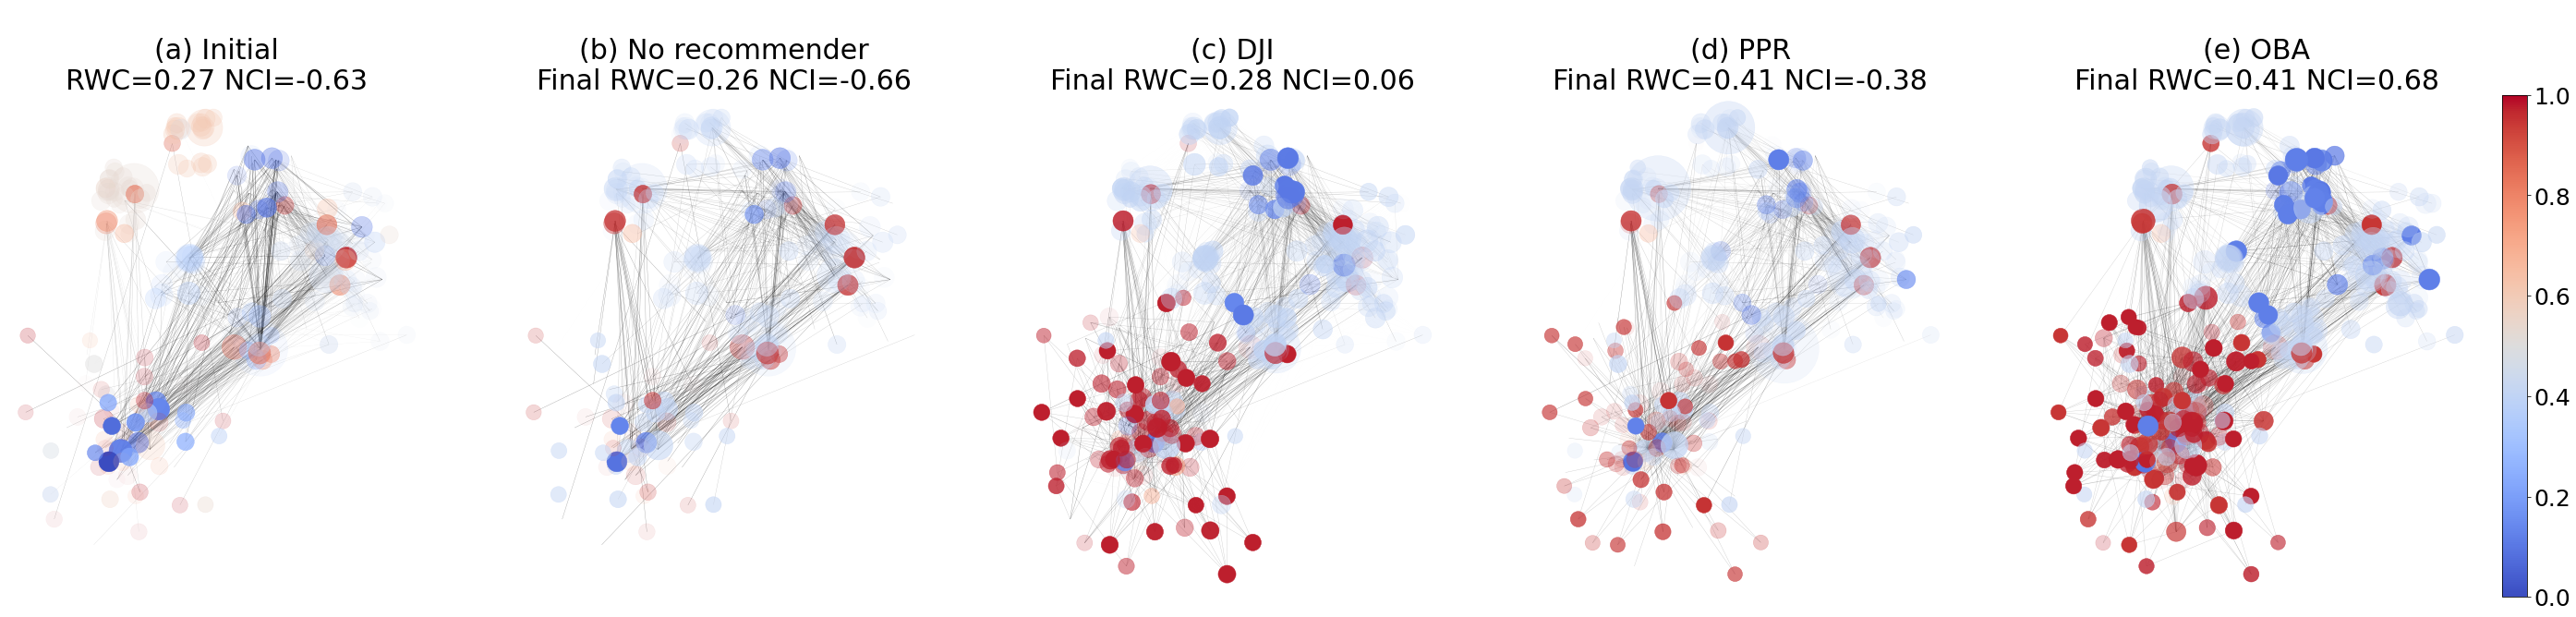

In [94]:
plt.show()

# Plot configurations

In [41]:
conf_mod2data = {(.2,.95): None,  (.8, .95): None, (.2,.05): None, (.8, .05): None, }

GRAPH_SEED = 0
POWER_LAW_EXP = 2.75
UNBALANCE_THRESHOLD = .05
rep = 0
for conf, mod in conf_mod2data.keys():
    G = None
    init_opinions = np.zeros(400)
    while G is None or not (0.5 - UNBALANCE_THRESHOLD < unbalancing(init_opinions) < 0.5 + UNBALANCE_THRESHOLD):
        G, init_opinions, node2community = generate_G_and_opinions(400, centrism=1.,
                                                                   mu=1-mod, power_law_coef=POWER_LAW_EXP, 
                                                                   conformism=conf, 
                                                                   avg_deg=12, 
                                                                   distr="uniform", seed=GRAPH_SEED+rep, 
                                                                   verbose=False, innovators_perc=.5)
        rep += 1
        assert rep < 10E3, 'Huston we have a problem'
    conf_mod2data[(conf, mod)] = (G.copy(), init_opinions.copy(), node2community)

In [97]:
G.number_of_edges()

5452

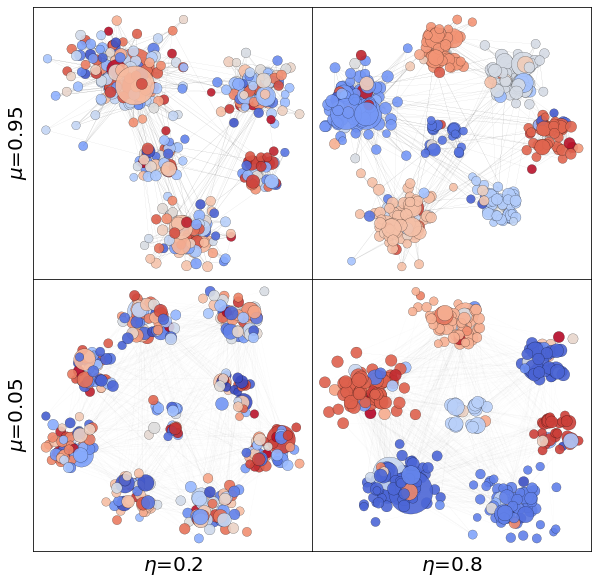

In [74]:
fig, axs = plt.subplots(2,2, figsize=(10, 10))

for n, (conf, mod) in enumerate(conf_mod2data.keys()):
    
    i = n//2
    j = n%2
    ax = axs[i,j]
    
    
    G, init_opinions, node2community = conf_mod2data[(conf,mod)]
    pos = create_pos_from_communities(node2community, G, seed=0)
    
    # cmap
    vmin, vmax = (0, 1) 
    cmap = plt.cm.coolwarm
    if i==1:
        ax.set_xlabel('$\eta$='+str(conf), size=20)
    if j==0:
        ax.set_ylabel('$\mu$='+str(mod), size=20)
    
    # edges
    width=.03 if i == 0 else .008
    alpha = .03 if i == 0 else .008
    edge_colors = 'black'
    p = 1/2 if i == 0 else 1/10
    edges_to_color = [(u,v) for u,v in G.edges if np.random.binomial(1, p)]
    nx.draw_networkx_edges(G, arrows=False, width=width, 
                           edgelist=edges_to_color, 
                           edge_color=edge_colors, pos=pos, ax=ax)
    # nodes
    scale_degree_size = 5
    edgecolors = 'black'
    node2degree = dict(G.degree)
    node_color = init_opinions
    alpha = .9
    nx.draw_networkx_nodes(G, node_color=node_color, cmap=cmap, vmin=vmin, vmax=vmax,
                           pos=pos, 
                           node_size=[node2degree[node] * scale_degree_size + 15. for node in G.nodes()], 
                           ax=ax, alpha=alpha, linewidths=.2, edgecolors=edgecolors)
    
plt.subplots_adjust(wspace=0, hspace=0) 
figures_path = "./figures"
if not os.path.exists(figures_path):
    os.makedirs(figures_path)
    
fig.savefig(os.path.join(figures_path, 'graphs_initial_configurations.pdf'),  
            bbox_inches = 'tight', pad_inches = 0)

plt.show()